# Install the required dependencies

In [1]:
!pip install ipyleaflet ipywidgets shapely whitebox geopandas rasterio matplotlib gdal fiona
from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00


# Utility Functions

Functions to reduce repeatability

In [ ]:
import os
import rasterio

def copy_raster_crs (output_file, input_file):
    with rasterio.open(input_file) as src:
      data = src.read(1)
      out_meta = src.meta.copy()
    with rasterio.open(output_file, 'w', **out_meta) as dst:
      dst.write(data, 1)

def copy_vector_crs (output_file, input_file):
  gdf_source = gpd.read_file(input_file)
  gdf_new = gdf_source[gdf_source['attribute'] == 'value'].copy()
  gdf_new.crs = gdf_source.crs
  # gdf_new = gdf_new.to_crs("EPSG:4326")
  # Save the new GeoDataFrame with the correct CRS
  gdf_new.to_file(output_file)

def raster_percentile(path, percentile=95):
    with rasterio.open(path) as r:
        arr = r.read(1, masked=True)

    return float(np.percentile(arr.compressed(), percentile))

def plot_vector(input_path, title):
    gdf = gpd.read_file(input_path)
    plt.figure(figsize=(8, 8))
    gdf.plot(edgecolor="black", facecolor="red", linewidth=0.5)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Downloading the required DEM

### Pick a location on map

In [ ]:
from ipyleaflet import Map, Marker

# Get Coords from the map
selected_coords = None
m = Map(center=(20, 78), zoom=5)
def handle_click(**kwargs):
    global selected_coords
    if kwargs.get("type") == "click":
        lat, lon = kwargs["coordinates"]
        selected_coords = (lat, lon)
        print("Clicked:", lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
m.on_interaction(handle_click)
m

Map(center=[20, 78], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

Clicked: 10.112105488596134 76.35390782063232


In [ ]:
from ipyleaflet import Map, Circle, Marker
from shapely.geometry import Point
import shapely.geometry
import shapely.ops

# Set the Coords as selected_x and selected_y values
# Replace the coords here if you don't wanna run the Map

selected_lat = selected_coords[0]
selected_lon = selected_coords[1]
# selected_lat = 10.123002265332584
# selected_lon = 76.34586934965698
print("Using coords:", selected_lat, selected_lon)
# Radius is in meters
RADIUS_IN_METERS = 1000
RADIUS_IN_DEGREE = RADIUS_IN_METERS / 111320
point = Point(selected_lon, selected_lat)
circle = point.buffer(RADIUS_IN_DEGREE)
circle_polygon_coords = [(y, x) for x, y in circle.exterior.coords]
# Circle Polygon is the working Area
print("Circle polygon generated. Example coords:")
print(circle_polygon_coords[:5])
circle_map = Map(center=(selected_lat, selected_lon), zoom=13)

circle_layer = Circle(
    location=(selected_lat, selected_lon),
    radius=RADIUS_IN_METERS,
    color="red",
    fill_color="red",
    fill_opacity=0.3
)
circle_map.add_layer(circle_layer)
circle_map.add_layer(Marker(location=(selected_lat, selected_lon)))
circle_map

Using coords: 10.123002265332584 76.34586934965698
Circle polygon generated. Example coords:
[(10.123002265332584, 76.35485246140689), (10.122121766407597, 76.35480920526848), (10.121249747168587, 76.35467985343351), (10.12039460563752, 76.35446565163086), (10.11956457729481, 76.35416866274099)]


Map(center=[10.123002265332584, 76.34586934965698], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Download the DEM of that area

W: 76.33688623790707 S: 10.114019153582674 E: 76.35485246140689 N: 10.131985377082493
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=10.114019153582674&north=10.131985377082493&west=76.33688623790707&east=76.35485246140689&outputFormat=GTiff&outputFormat=GTiff&API_Key=34e829805c239fac71c013bb28bb0ffa
Starting DEM Download
DEM saved as dem.tif!


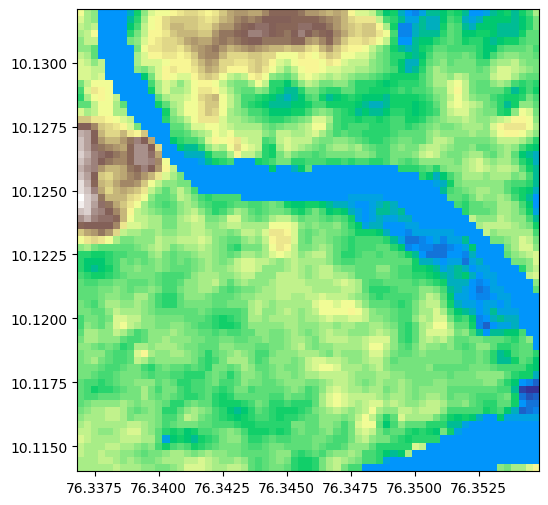

In [ ]:
import getpass
import requests
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# API KEY
# API_KEY = getpass("Enter your OpenTopography API key: ")

# Use Elevation API to download the DEM 30m
# Ensure we did not miss the polygon
polygon = Polygon([(lon, lat) for lat, lon in circle_polygon_coords])
# Get Bounding Box Values
minx, miny, maxx, maxy = polygon.bounds
print("W:", minx, "S:", miny, "E:", maxx, "N:", maxy)
# Create Download URL as per opentopography needs
url = (f"https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south={miny}&north={maxy}&west={minx}&east={maxx}&outputFormat=GTiff&outputFormat=GTiff&API_Key={API_KEY}")
# Checking URL
print(url)
print("Starting DEM Download")
response = requests.get(url)

# If Downloaded show the DEM otherwise show an error message
if response.status_code != 200:
    print("ERROR:", response.text)
else:
    with open("dem_4326.tif", "wb") as f:
        f.write(response.content)

    print("DEM saved as dem_4326.tif!")

    # Display DEM
    with rasterio.open("dem_4326.tif") as src:
        plt.figure(figsize=(6, 6))
        show(src, cmap="terrain")

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal

# Convert the DEM 4326 to DEM 3857
# Input and output file paths
input_dem = '/content/dem_4326.tif'
output_dem = '/content/dem_3857.tif'
# Convert using GDAL
src_ds = gdal.Open(input_dem)
dst_srs = 'EPSG:3857'
gdal.Warp(output_dem, src_ds, dstSRS=dst_srs)
src_ds = None
print(f"Reprojected DEM saved as {output_dem}")

Reprojected DEM saved as /content/dem_3857.tif


/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Clip the DEM to circle_polygon

In [ ]:
import os
import geopandas as gpd
from shapely.geometry import Polygon

# Make Point
gdf_point = gpd.GeoDataFrame({"id": [1]}, geometry=[point], crs="EPSG:4326")
gdf_point = gdf_point.to_crs("EPSG:3857")
# Make Buffer
buffer = gdf_point.geometry.buffer(1000)
gdf_buffer = gpd.GeoDataFrame({"id": [1]}, geometry=buffer, crs="EPSG:3857")
os.makedirs("mask/circle_area", exist_ok=True)
output_path = "mask/circle_area/circle_buffer.shp"
gdf_buffer.to_file(output_path)
print("Shapefile saved at:", output_path)

Shapefile saved at: mask/circle_area/circle_buffer.shp


WBT working directory: /content
Clipped DEM saved as: /content/clipped_dem.tif


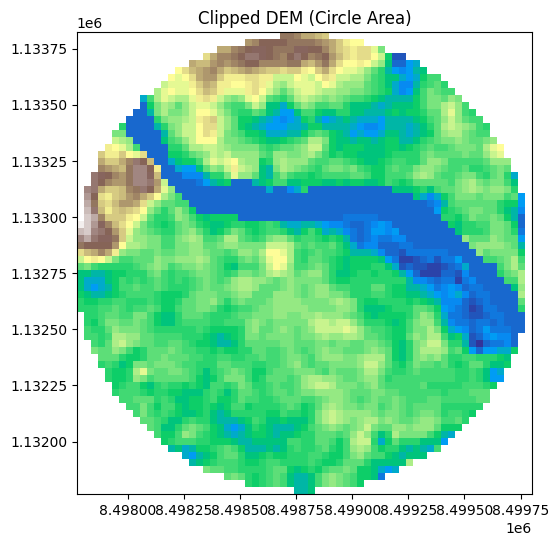

In [ ]:
from whitebox import WhiteboxTools
import inspect
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import os
import subprocess
import fiona

wbt = WhiteboxTools()

# Set working directory and See if it works
wbt.set_working_dir(os.getcwd())
wbt_dir = wbt.get_working_dir()
print("WBT working directory:", wbt_dir)
# print(os.listdir(wbt_dir))

# Create a Clipped_DEM
# Input and Output Path
input_path= "/content/dem_3857.tif"
output_path ="/content/clipped_dem.tif"
mask_path = "/content/mask/circle_area/circle_buffer.shp"

dem_path= "/content/dem_3857.tif"
polygon_path = "/content/mask/circle_area/circle_buffer.shp"

gdal.Warp(
    destNameOrDestDS=output_path,
    srcDSOrSrcDSTab=input_path,
    cutlineDSName=mask_path,
    cropToCutline=True,     # restrict raster to polygon area
    dstNodata=-9999,        # set nodata outside polygon
    warpOptions=["CUTLINE_ALL_TOUCHED=TRUE"],  # match QGIS behavior
)
print("Clipped DEM saved as:", output_path)
with rasterio.open(output_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("Clipped DEM (Circle Area)")
    show(src, cmap="terrain")

# Start With DEM Processing
Prepare Required Raster and Vector Layers such as depression filled layer, flow direction (d8 pointer), flow accumulation (d8 flow accumulation), ponding depth layer, slope layer and slope layer in radian.

### Fill the Depressions
Output: filled_dem.tif

./whitebox_tools --run="FillDepressions" --wd="/content" --dem='/content/dem_3857.tif' --output='/content/filled_dem.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 50%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depressions: 14%
Filling depressions: 15%
Filling depressions: 16%
Filling depressions: 17%
Filling depressions: 18%
Filling depressions: 19%
Filling depressions: 20%
Filling depressions: 21%
Filling depressions: 22%
Filling depressions: 23%
Filling depressions: 24%
Fill

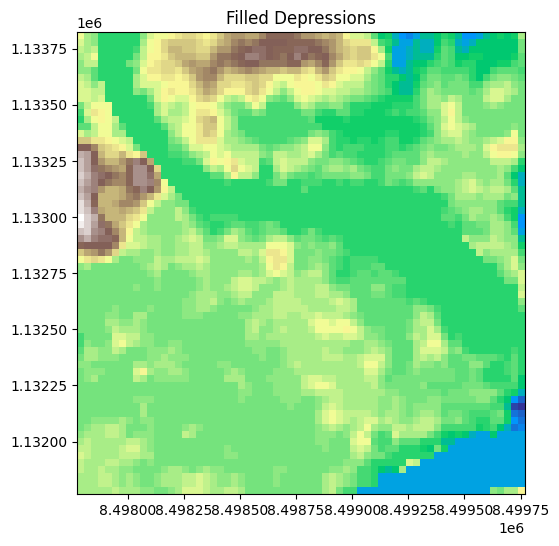

In [ ]:
from whitebox import WhiteboxTools
import os
import inspect

# Start with filling depression
# Results in: filled_dem.tif
wbt = WhiteboxTools()
wbt.set_working_dir("/content")

# Paths
# Input and Output
# input_path = "/content/clipped_dem.tif"
input_path = "/content/dem_3857.tif"
output_path = "/content/filled_dem.tif"

# print(inspect.getsource(wbt.fill_depressions))
wbt.fill_depressions(
    dem=input_path,
    output=output_path
)
print("Filled DEM saved as:", output_path)
# copy_raster_crs(output_path, input_path)
with rasterio.open(output_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("Filled Depressions")
    show(src, cmap="terrain")

### Calculate the D8 Pointer
Output: d8_pointer.tif

./whitebox_tools --run="D8Pointer" --dem='/content/filled_dem.tif' --output='/content/d8_pointer.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progress: 67%
Progress: 69%
Progress: 70%
Progress: 72%
Progress: 73%
Progress: 75%
Progress: 76%
P

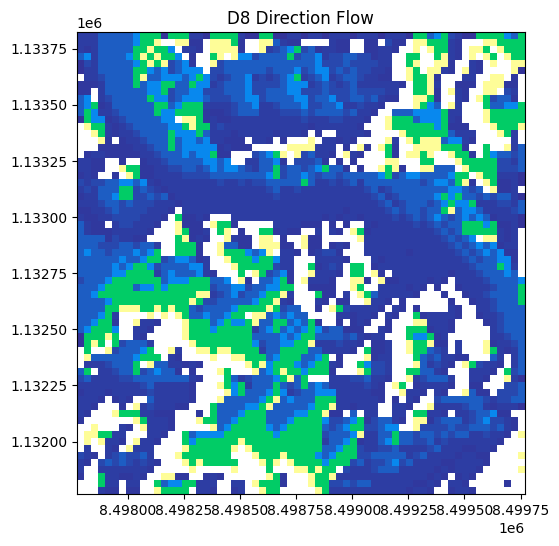

In [ ]:
from whitebox import WhiteboxTools
import os
import inspect

# This is calculated for the direction of the flow
wbt = WhiteboxTools()
# Paths
# Input and Output
input_path = "/content/filled_dem.tif"
output_path = "/content/d8_pointer.tif"

# print(inspect.getsource(wbt.d8_pointer))
wbt.d8_pointer(
    dem = input_path,
    output = output_path
)
print("D8 Pointer saved as:", output_path)
# copy_raster_crs(output_path, input_path)

with rasterio.open(output_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("D8 Direction Flow")
    show(src, cmap="terrain")

### Calculate the D8 Flow Accumulation
Output: d8_flow_acc.tif

./whitebox_tools --run="D8FlowAccumulation" --wd="/content" --input='/content/filled_dem.tif' --output='/content/d8_flow_acc.tif' --out_type=cells -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 3%
Flow directions: 4%
Flow directions: 6%
Flow directions: 7%
Flow directions: 9%
Flow directions: 10%
Flow directions: 12%
Flow directions: 13%
Flow directions: 15%
Flow directions: 16%
Flow directions: 18%
Flow directions: 20%
Flow directions: 21%
Flow directions: 23%
Flow directions: 24%
Flow directions: 26%
Flow directions: 27%
Flow directions: 29%
Flow directions: 30%
Flow directions: 32%
Flow directions: 33%
Flow directions: 35%
Flow directions: 36%
Flow directions: 38%
Flow directions: 40%
Flow directions: 41%
Flow directions: 43%
Flow directions: 44%
Flow directions

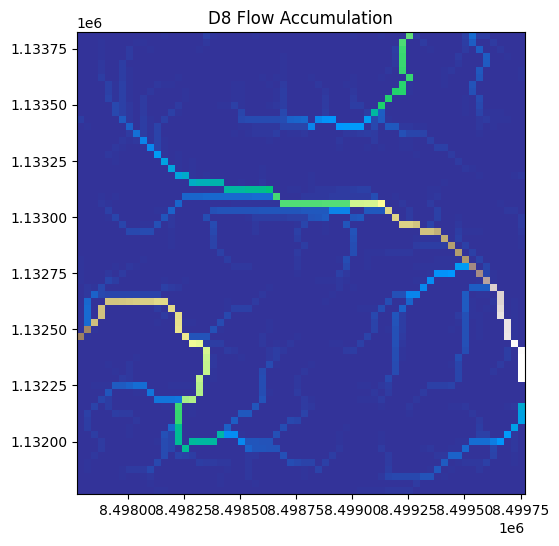

In [ ]:
from whitebox import WhiteboxTools
import os
import inspect

# This is the accumulation of water across the terrain
wbt = WhiteboxTools()
wbt.set_working_dir("/content")

# Paths
# Input and Output
input_path = "/content/filled_dem.tif"
output_path = "/content/d8_flow_acc.tif"
# print(inspect.getsource(wbt.d8_flow_accumulation))
wbt.d8_flow_accumulation(
    i = input_path,
    output = output_path
)
print("D8 Flow Accumulation saved as:", output_path)
# fix_crs_inplace(output_path, input_path)
with rasterio.open(output_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("D8 Flow Accumulation")
    show(src, cmap="terrain")

### Calculate Ponding Depth
Output: ponding_depth.tif

Ponding Depth saved as: /content/ponding_depth.tif


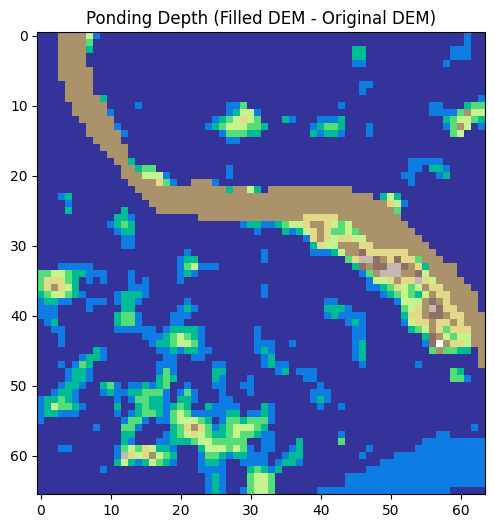

In [ ]:
import rasterio
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt

# Calculate Ponding Depth
# Ponding Depth = Filled Dem - Clipped Dem (Depression filled layer - Original Layer)
input_original_path = "/content/dem_3857.tif"
input_filled_path = "/content/filled_dem.tif"
output_path = "/content/ponding_depth.tif"

with rasterio.open(input_original_path) as orig, rasterio.open(input_filled_path) as filled:
      orig_data = orig.read(1)
      filled_data = filled.read(1)
      pond_data = filled_data - orig_data
      # Make sure there are no negatives in case dem clipping is wrong
      pond_data = np.where(pond_data < 0, 0, pond_data)
      profile = orig.profile
      # Write the file
      with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(pond_data.astype(np.float32), 1)
      print("Ponding Depth saved as:", output_path)

      plt.figure(figsize=(6,6))
      # show(pond_data, cmap="terrain")
      plt.title("Ponding Depth (Filled DEM - Original DEM)")
      show(pond_data, cmap="terrain")
      # show(pond_data, cmap="Blues")

### Calculate Slope (in degrees)
Output: slope.tif

./whitebox_tools --run="Slope" --wd="/content" --dem='/content/filled_dem.tif' --output='/content/slope.tif' --zfactor='1.0' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progress: 67%
Progress: 69%
Progress: 70%
Progress: 72%
Progress: 73%
Progre

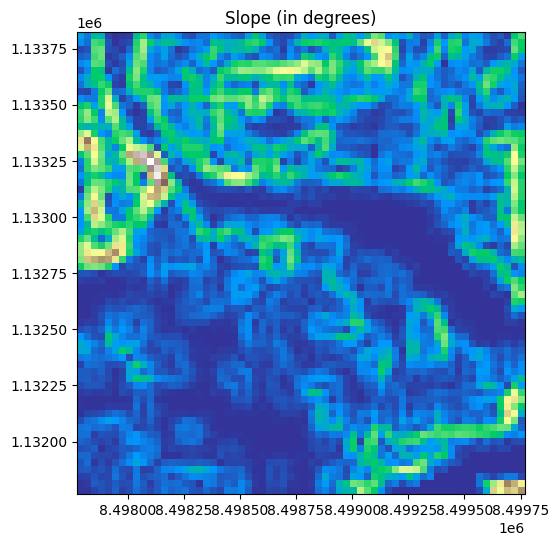

In [ ]:
from whitebox import WhiteboxTools
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Calculate Slope
wbt = WhiteboxTools()
wbt.set_working_dir("/content")
# Paths
input_path = "/content/filled_dem.tif"
ouput_path = "/content/slope.tif"
# print(inspect.getsource(wbt.slope))
wbt.slope(
    dem = input_path,
    output = ouput_path,
    zfactor = 1.0,
    units = "degrees"
)
print("Slope (in degrees) saved as:", ouput_path)
with rasterio.open(ouput_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("Slope (in degrees)")
    show(src, cmap="terrain")

### Calculate Slope (in radians)
Output: slope_radians.tif

    def slope(self, dem, output, zfactor=None, units="degrees", callback=None):
        """Calculates a slope raster from an input DEM.

        Keyword arguments:

        dem -- Input raster DEM file.
        output -- Output raster file.
        zfactor -- Optional multiplier for when the vertical and horizontal units are not the same.
        units -- Units of output raster; options include 'degrees', 'radians', 'percent'.
        callback -- Custom function for handling tool text outputs.
        """
        args = []
        args.append("--dem='{}'".format(dem))
        args.append("--output='{}'".format(output))
        if zfactor is not None:
            args.append("--zfactor='{}'".format(zfactor))
        args.append("--units={}".format(units))
        return self.run_tool("slope", args, callback)  # returns 1 if error

./whitebox_tools --run="Slope" --wd="/content" --dem='/content/filled_dem.tif' --output='/content/slope_radians.tif' --zfactor='1.0' --units=radians -v --comp

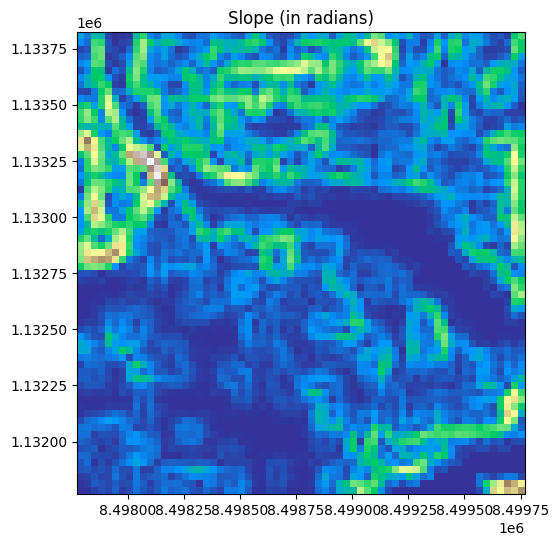

In [ ]:
from whitebox import WhiteboxTools
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Calculate Slope (in Radians)
wbt = WhiteboxTools()
wbt.set_working_dir("/content")
# Paths
input_path = "/content/filled_dem.tif"
output_path = "/content/slope_radians.tif"
print(inspect.getsource(wbt.slope))
wbt.slope(
    dem = input_path,
    output = output_path,
    zfactor = 1.0,
    units = "radians"
)
print("Slope (in radians) saved as:", output_path)
with rasterio.open(output_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("Slope (in radians)")
    show(src, cmap="terrain")

# Calculating the Hotspot Indices
Calculating indices such as Stream Power Index (SPI) and Topographic Wetness Index (TWI)

## Calculate SPI
Output: spi.tif

SPI = Flow Accumulation * tan (Slope in Radians)

In case of GIS Analysis:

SPI = (Flow Accumulation * Cell Size) * tan (Slope in Radians)

where Cell Size is 30 which is the cell size of our DEM file 30m

./whitebox_tools --run="StreamPowerIndex" --wd="/content" --sca='/content/d8_flow_acc.tif' --slope='/content/slope_radians.tif' --output='/content/spi.tif' --exponent=1.0 -v --compress_rasters=False

*******************************
* Welcome to StreamPowerIndex *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progress: 67%
P

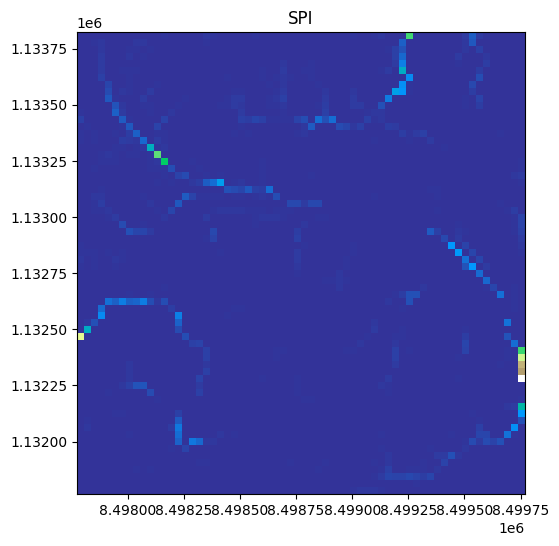

In [ ]:
import rasterio
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Calculating the SPI
input_flow_acc_path = "/content/d8_flow_acc.tif"
input_slope_radians_path = "/content/slope_radians.tif"
output_spi = "/content/spi.tif"
cell_size = 30

# Whitebox SPI Calculation
wbt = WhiteboxTools()
wbt.set_working_dir("/content")
# print(inspect.getsource(wbt.stream_power_index))
wbt.stream_power_index(
    sca = input_flow_acc_path,
    slope = input_slope_radians_path,
    output = output_spi
)
print("SPI saved as:", output_spi)
with rasterio.open(output_spi) as src:
    plt.figure(figsize=(6,6))
    plt.title("SPI")
    show(src, cmap="terrain")

# # Load Rasters for raster calculation
# with rasterio.open(input_flow_acc_path) as fa_src, rasterio.open(input_slope_radians_path) as sl_src:
#     flow_acc = fa_src.read(1).astype("float32")
#     slope_rad = sl_src.read(1).astype("float32")
#     # 1. Calculate Raw Stream Power Term (As * tan(beta))
#     # Avoid tan(0) by using a tiny non-zero slope
#     slope_tan = np.tan(np.where(slope_rad == 0, 0.0001, slope_rad))
#     raw_stream_power = (flow_acc * cell_size) * slope_tan
#     # 2. Handle Zero/Negative Values BEFORE log transformation
#     # Add a tiny epsilon (e.g., 1e-6) to avoid ln(0) or ln(<0) for non-flow areas
#     # This is a standard procedure in calculating SPI/TWI.
#     SPI_INPUT = np.where(raw_stream_power <= 0, 1e-6, raw_stream_power)
#     # 3. Apply the Natural Logarithm (ln) to get the final SPI
#     spi_final = np.log(SPI_INPUT)
#     profile = fa_src.profile
#     profile.update(dtype="float32")
#     # Save the File
#     with rasterio.open(output_spi, "w", **profile) as dst:
#         dst.write(spi_final.astype("float32"), 1)
#     print("Stream Power Index (SPI) saved as:", output_spi)
#     plt.figure(figsize=(6,6))
#     # plt.imshow(spi_final, cmap="magma", norm=LogNorm())
#     plt.imshow(spi_final, cmap="terrain")
#     plt.title("SPI - Stream Power Index")
#     plt.colorbar(label="SPI")
#     plt.show()

## Calculate TWI

Output: tw.tif

TWI = Flow Accumulation / tan (Slope in Radians)

In case of GIS Analysis:

SPI = (Flow Accumulation * Cell Size) / tan (Slope in Radians)

where Cell Size is 30 which is the cell size of our DEM file 30m

./whitebox_tools --run="WetnessIndex" --wd="/content" --sca='/content/d8_flow_acc.tif' --slope='/content/slope_radians.tif' --output='/content/twi.tif' -v --compress_rasters=False

****************************
* Welcome to WetnessIndex  *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progress: 67%
Progress: 69%
Progress: 70%
Progres

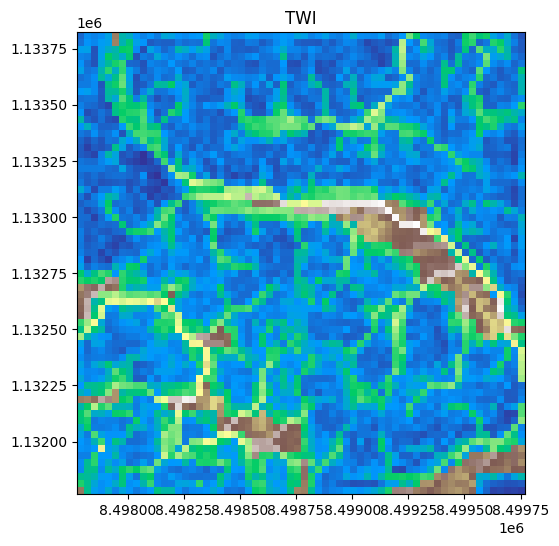

In [ ]:
# Calculating the SPI
input_flow_acc_path = "/content/d8_flow_acc.tif"
input_slope_radians_path = "/content/slope_radians.tif"
output_spi = "/content/twi.tif"
cell_size = 30

# Whitebox SPI Calculation
# wbt = WhiteboxTools()
# wbt.set_working_dir("/content")
# print(inspect.getsource(wbt.stream_power_index))
wbt.wetness_index(
    sca = input_flow_acc_path,
    slope = input_slope_radians_path,
    output = output_spi
)
print("TWI saved as:", output_spi)
with rasterio.open(output_spi) as src:
    plt.figure(figsize=(6,6))
    plt.title("TWI")
    show(src, cmap="terrain")

## Calculate Streams

Get Extract Stream Data - We use 100 as Threhsold because of our 30m DEM resolution

./whitebox_tools --run="ExtractStreams" --wd="/content" --flow_accum='/content/d8_flow_acc.tif' --output='/content/streams.tif' --threshold='100' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progress: 67%
Progress: 69%
Progress: 70%
Progress

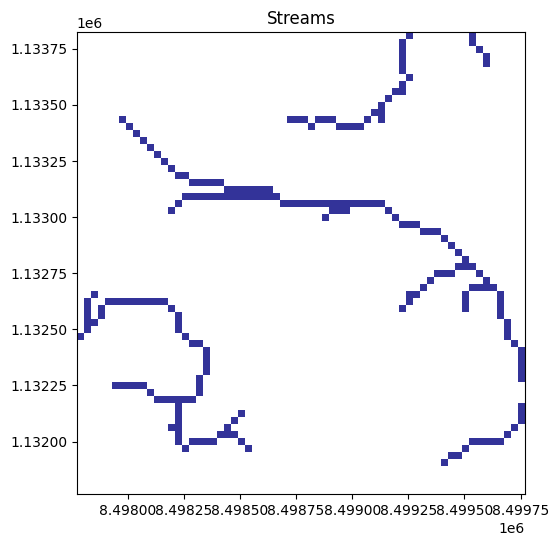

In [ ]:
# Calculating the Streams
input_flow_acc_path = "/content/d8_flow_acc.tif"
output_streams_path = "/content/streams.tif"
threshold = 100

# Whitebox Stream Calculation
# print(inspect.getsource(wbt.extract_streams))
wbt.extract_streams(
    flow_accum = input_flow_acc_path,
    output = output_streams_path,
    threshold = threshold
)
print("Streams saved as:", output_streams_path)
with rasterio.open(output_streams_path) as src:
    plt.figure(figsize=(6,6))
    plt.title("Streams")
    show(src, cmap="terrain")

## Calculate Quantiles

95th Percentile Quantile for SPI

40th Percentile for depth analysis

In [ ]:
input_spi_path = "/content/spi.tif"
spi_threshold = raster_percentile(input_spi_path, 95)
print("95th Percentile for SPI: ", quantile_spi)

95th Percentile for SPI:  0.027405662462115288


# Check Dam Hotspots

Use the 95th Percentile of the SPI layer to filter spi_hotspots

95th Percentile for SPI:  0.027405662462115288
./whitebox_tools --run="RasterCalculator" --wd="/content" --statement=("/content/spi.tif" > 0.027405662462115288) --output='/content/spi_hotspots.tif' -v --compress_rasters=False

*******************************
* Welcome to RasterCalculator *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Reading data...
Reading data: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64

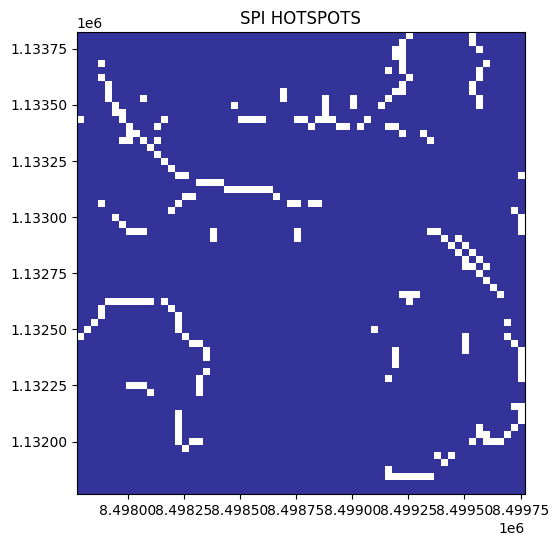

In [ ]:
input_spi_path = "/content/spi.tif"
output_spi_hotspots = "/content/spi_hotspots.tif"
output_spi_hotspots_mask = "/content/spi_hotspots_mask.tif"

SPI_THRESHOLD = raster_percentile(input_spi_path, 95)
expression = f'("{input_spi_path}" > {SPI_THRESHOLD})'

print("95th Percentile for SPI: ", SPI_THRESHOLD)
# print(inspect.getsource(wbt.raster_calculator))
wbt.raster_calculator(
    statement = expression,
    output  = output_spi_hotspots,
)
print("SPI Hotspots saved as:", output_spi_hotspots)
with rasterio.open(output_spi_hotspots) as src:
    plt.figure(figsize=(6,6))
    plt.title("SPI HOTSPOTS")
    show(src, cmap="terrain")

## Vectorization

- Turn SPI Hotspots into Vector. Output: spi_hotspot_vector.shp
- Turn Stream into a Vector (Stream layer is binary already). Output: streams_vector

./whitebox_tools --run="RasterToVectorPolygons" --wd="/content" --input='/content/spi_hotspots.tif' --output='/content/spi_hotspots_vector/spi_hotspots_vector.shp' -v --compress_rasters=False

*************************************
* Welcome to RasterToVectorPolygons *
* Powered by WhiteboxTools          *
* www.whiteboxgeo.com               *
*************************************
Reading data...
Clumping polygons: 0%
Clumping polygons: 1%
Clumping polygons: 3%
Clumping polygons: 4%
Clumping polygons: 6%
Clumping polygons: 7%
Clumping polygons: 9%
Clumping polygons: 10%
Clumping polygons: 12%
Clumping polygons: 13%
Clumping polygons: 15%
Clumping polygons: 16%
Clumping polygons: 18%
Clumping polygons: 20%
Clumping polygons: 21%
Clumping polygons: 23%
Clumping polygons: 24%
Clumping polygons: 26%
Clumping polygons: 27%
Clumping polygons: 29%
Clumping polygons: 30%
Clumping polygons: 32%
Clumping polygons: 33%
Clumping polygons: 35%
Clumping polygons: 36%
Clumping polygons: 38%
Clumping p

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:200: RuntimeWarning: /content/spi_hotspots_vector/spi_hotspots_vector.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<Figure size 800x800 with 0 Axes>

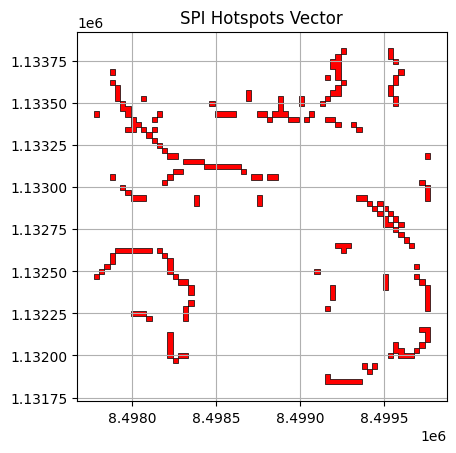

In [ ]:
# Make SPI Hotspot To Vector
input_spi_hotspots_path = "/content/spi_hotspots.tif"
output_spi_hotspots_vector = "/content/spi_hotspots_vector/spi_hotspots_vector.shp"
wbt.raster_to_vector_polygons(
    i = input_spi_hotspots_path,
    output  = output_spi_hotspots_vector,
)

# gdf = gpd.read_file("/content/spi_hotspots_vector/spi_hotspots_vector.shp");
plot_vector(output_spi_hotspots_vector, "SPI Hotspots Vector")

./whitebox_tools --run="RasterToVectorLines" --wd="/content" --input='/content/streams.tif' --output='/content/streams_hotspots_vector/streams_hotspots_vector.shp' -v --compress_rasters=False

**********************************
* Welcome to RasterToVectorLines *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progres

<Figure size 800x800 with 0 Axes>

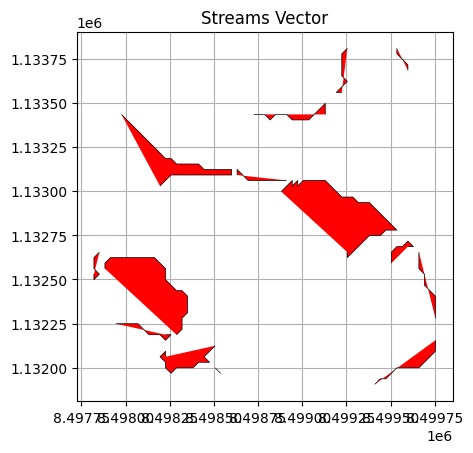

In [ ]:
# Make Streams To Vector
input_streams_path = "/content/streams.tif"
output_streams_vector = "/content/streams_vector/streams_vector.shp"
wbt.raster_to_vector_lines(
    i = input_streams_path,
    output  = output_streams_vector,
)
plot_vector(output_streams_vector, "Streams Vector")

## Get Check-Dam Hotspot Area

- Clip SPI Hotspots Vector and Stream Vector to find intersecting area




./whitebox_tools --run="Clip" --wd="/content" --input='/content/streams_vector/streams_vector.shp' --clip='/content/spi_hotspots_vector/spi_hotspots_vector.shp' --output='/content/check_dam_vector_intersection/vector_intersection.shp' -v --compress_rasters=False

****************************
* Welcome to Clip          *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 7%
Progress: 14%
Progress: 21%
Progress: 28%
Progress: 35%
Progress: 42%
Progress: 50%
Progress: 57%
Progress: 64%
Progress: 71%
Progress: 78%
Progress: 85%
Progress: 92%
Progress: 100%
Saving data...
Output file written
Elapsed Time: 0.2s


<Figure size 800x800 with 0 Axes>

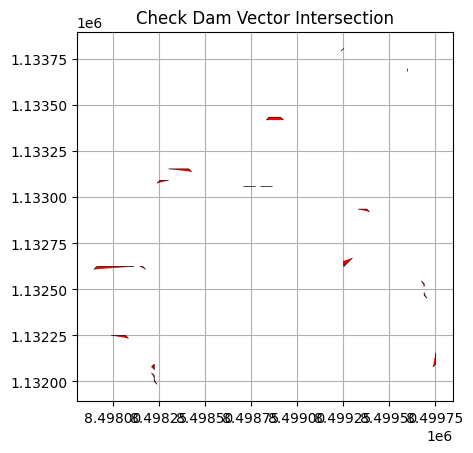

In [ ]:
# Clip SPI Hotspot Vector and Streams Vector
input_spi_hotspots_vector_path = "/content/spi_hotspots_vector/spi_hotspots_vector.shp"
input_streams_vector_path = "/content/streams_vector/streams_vector.shp"
output_vector_intersection = "/content/check_dam_vector_intersection/vector_intersection.shp"
wbt.clip(
    i = input_streams_vector_path,
    clip  = input_spi_hotspots_vector_path,
    output = output_vector_intersection
)
plot_vector(output_vector_intersection, "Check Dam Vector Intersection")

## Check Dam Finalization

- Add Points to checkdam candidates
- Add additional attributes to Vector Candidates such as SPI, Lon, Lat, Elevation, Slope and a C_ID.
- Export both Vector and CSV

/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:917: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


<Figure size 800x800 with 0 Axes>

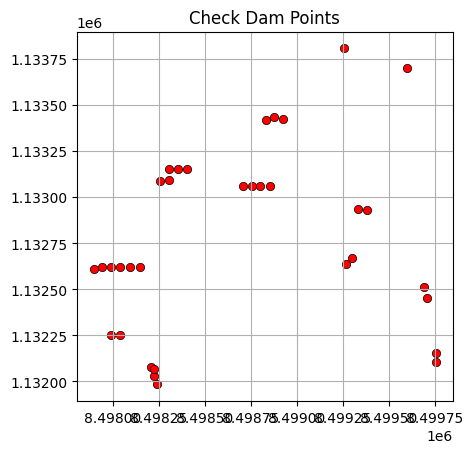

In [ ]:
# Draw points across candidates
import geopandas as gpd
from shapely.geometry import LineString

input_vector_intersection_path = "/content/check_dam_vector_intersection/vector_intersection.shp"
output_check_dam_points = "/content/check_dam_points/check_dam_points.shp"

gdf = gpd.read_file(input_vector_intersection_path)
points = []
# 50 Meter distance amongst the Check Dams as requried
interval = 50

for idx, row in gdf.iterrows():
    line = row.geometry
    length = line.length
    d = 0
    while d <= length:
        pt = line.interpolate(d)
        points.append(pt)
        d += interval

gpd.GeoDataFrame(geometry=points).to_file(output_check_dam_points)
plot_vector(output_check_dam_points, "Check Dam Points")

./whitebox_tools --run="ExtractRasterValuesAtPoints" --wd="/content" --inputs='/content/slope.tif;/content/spi.tif;/content/twi.tif;/content/filled_dem.tif' --points='/content/check_dam_points/check_dam_points.shp' -v --compress_rasters=False

******************************************
* Welcome to ExtractRasterValuesAtPoints *
* Powered by WhiteboxTools               *
* www.whiteboxgeo.com                    *
******************************************
Reading data...
Reading data...
Reading data...
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.17s


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:917: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


   FID                         geometry  STRM_VAL    distance    VALUE1  \
0    0  POINT (8499254.781 1133807.713)       1.0         0.0  3.438615   
1    1  POINT (8499597.624 1133698.627)       2.0  134.906405  1.181183   
2    2  POINT (8498304.171 1133153.195)       3.0  443.449262  0.191889   
3    3  POINT (8498354.171 1133153.195)       3.0  493.449262  1.261212   
4    4  POINT (8498404.171 1133153.195)       3.0  543.449262  2.963264   

     VALUE2     VALUE3    VALUE4  RANK_SCORE  
0  0.623240  13.249945  1.000000    2.030927  
1  0.037060  12.564665  6.000013    0.609122  
2  0.018997  15.531115  8.000247    0.105443  
3  0.129855  13.687425  8.000238    0.695534  
4  0.321347  12.885092  8.000229    1.642305  


<Figure size 800x800 with 0 Axes>

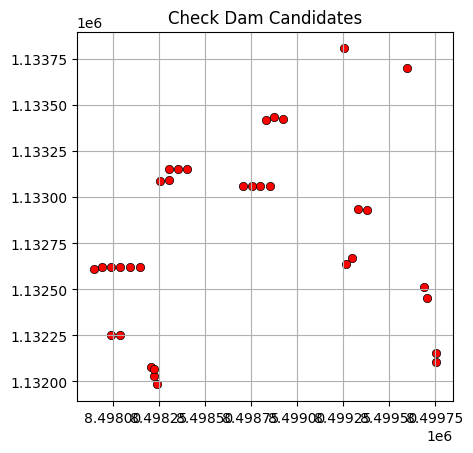

In [ ]:
# # Add required Attributes to the Vector
input_check_dam_points = "/content/check_dam_points/check_dam_points.shp"
input_slope_path = "/content/slope.tif"
input_spi = "/content/spi.tif"
input_filled_dem = "/content/filled_dem.tif"
input_twi = "/content/twi.tif"

input_streams_vector = "/content/streams_vector/streams_vector.shp"

# # Added STRM VAL
# streams = gpd.read_file(input_streams_vector)
# streams["STRM_VAL"] = streams["FID"]
# print(streams.columns)
# points = gpd.read_file(input_check_dam_points)
# points = points.set_crs(epsg=3857)
# joined = gpd.sjoin(
#     points,
#     streams[["STRM_VAL", "geometry"]],
#     how="left",
#     predicate="intersects"
# )
# joined = joined.drop(columns=["index_right"], errors="ignore")
# print(joined.columns)

# # Added a distance for hydro analysis between check dam distance
# joined["distance"] = None
# for stream_id, group in joined.groupby("STRM_VAL"):
#     line = streams.loc[streams["STRM_VAL"] == stream_id].geometry.values[0]
#     joined.loc[group.index, "distance"] = group.geometry.apply(lambda pt: line.project(pt))

# # Added Other rankings
# raster = f"{input_slope_path};{input_spi};{input_twi};{input_filled_dem}"
# wbt.extract_raster_values_at_points(
#     inputs=raster,
#     points=input_check_dam_points,
# )
# updated_points = gpd.read_file(input_check_dam_points)

# # Added a RANK SCORE
# joined = joined.merge(updated_points[["FID", "VALUE1", "VALUE2", "VALUE3", "VALUE4"]], on="FID")
# W1 = 0.5  # slope weight
# W2 = 0.5  # spi weight
# joined["RANK_SCORE"] = W1 * joined["VALUE1"] + W2 * joined["VALUE2"]
# print(joined.head())
# plot_vector(input_check_dam_points, "Check Dam Candidates")

# CLEAN OLD VALUE COLUMNS
pts = gpd.read_file(input_check_dam_points)
cols_to_remove = [c for c in pts.columns if c.startswith("VALUE")]
pts = pts.drop(columns=cols_to_remove, errors="ignore")
pts.to_file(input_check_dam_points)

# STEP 1 — Load streams and points
streams = gpd.read_file(input_streams_vector)
streams["STRM_VAL"] = streams["FID"]

points = gpd.read_file(input_check_dam_points)
points = points.set_crs(epsg=3857)

joined = gpd.sjoin(points, streams[["STRM_VAL", "geometry"]],
                   how="left", predicate="intersects")
joined = joined.drop(columns=["index_right"], errors="ignore")

# STEP 2 — Add distance
joined["distance"] = None
for stream_id, group in joined.groupby("STRM_VAL"):
    line = streams.loc[streams["STRM_VAL"] == stream_id].geometry.values[0]
    joined.loc[group.index, "distance"] = group.geometry.apply(lambda pt: line.project(pt))
joined.to_file(input_check_dam_points)

# STEP 3 — Extract raster values (NOW CLEAN)
wbt.extract_raster_values_at_points(
    inputs=f"{input_slope_path};{input_spi};{input_twi};{input_filled_dem}",
    points=input_check_dam_points,
)

updated_points = gpd.read_file(input_check_dam_points)

# STEP 4 — merge clean raster values
joined = joined.merge(
    updated_points[["FID", "VALUE1", "VALUE2", "VALUE3", "VALUE4"]],
    on="FID"
)

# STEP 5 — Rank score
W1 = 0.5
W2 = 0.5
joined["RANK_SCORE"] = W1 * joined["VALUE1"] + W2 * joined["VALUE2"]
joined.to_file(input_check_dam_points)
print(joined.head())
plot_vector(input_check_dam_points, "Check Dam Candidates")

# Ranker

In [ ]:
# Ranker

import geopandas as gpd

def rank_check_dams(
    input_shp,
    slope_field="slope",
    spi_field="spi",
    w_slope=0.4,
    w_spi=0.3,
    output_shp=None
):
    """
    Ranks check dam candidate points using a weighted score.

    Parameters
    ----------
    input_shp : str
        Path to input shapefile containing the attributes.
    slope_field : str
        Name of the slope attribute column.
    spi_field : str
        Name of the SPI attribute column.
    w_slope : float
        Weight assigned to slope.
    w_spi : float
        Weight assigned to SPI.
    output_shp : str or None
        Path where the updated shapefile will be written.
        If None, overwrites the original file.
    """

    print(f"Loading: {input_shp}")
    gdf = gpd.read_file(input_shp)

    # Check required fields
    for col in [slope_field, spi_field]:
        if col not in gdf.columns:
            raise ValueError(f"Missing field '{col}' in the shapefile.")

    # STEP 1 — Compute weighted score
    gdf["RANK_SCORE"] = (
        w_slope * gdf[slope_field] +
        w_spi * gdf[spi_field]
    )

    # STEP 2 — Generate rank (highest score = rank 1)
    gdf["RANK"] = (
        gdf["RANK_SCORE"]          # sort by score
        .rank(method="dense", ascending=False)
        .astype(int)
    )

    # STEP 3 — Save
    if output_shp is None:
        output_shp = input_shp  # overwrite input
        print("Overwriting input shapefile with updated ranking…")
    else:
        print(f"Writing ranked output to: {output_shp}")

    gdf.to_file(output_shp)

    print("Ranking complete.\n")
    print(gdf[["RANK", "RANK_SCORE", slope_field, spi_field"]].head())

    return gdf

rank_check_dams(
    input_shp="check_dams_4326.shp",
    slope_field="VALUE1",   # your slope attribute
    spi_field="VALUE2",     # your SPI attribute
    w_slope=0.4,
    w_spi=0.3,
    output_shp="ranked_check_dams.shp"
)


./whitebox_tools --run="AddPointCoordinatesToTable" --wd="/content" --input='/content/check_dam_points_4326/check_dam_points_4326.shp' -v --compress_rasters=False

*****************************************
* Welcome to AddPointCoordinatesToTable *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Progress: 2%
Progress: 5%
Progress: 8%
Progress: 11%
Progress: 14%
Progress: 17%
Progress: 20%
Progress: 23%
Progress: 26%
Progress: 29%
Progress: 32%
Progress: 35%
Progress: 38%
Progress: 41%
Progress: 44%
Progress: 47%
Progress: 50%
Progress: 52%
Progress: 55%
Progress: 58%
Progress: 61%
Progress: 64%
Progress: 67%
Progress: 70%
Progress: 73%
Progress: 76%
Progress: 79%
Progress: 82%
Progress: 85%
Progress: 88%
Progress: 91%
Progress: 94%
Progress: 97%
Progress: 100%
Saving data...
Output file written
Elapsed Time: 0.1s


<Figure size 800x800 with 0 Axes>

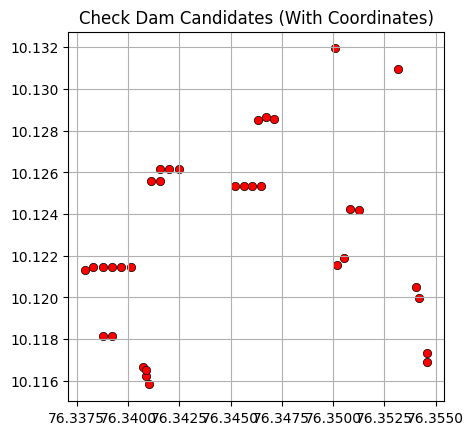

In [ ]:
# Add Cordinates for Lon/Lat
# First change the Vector from meter based to coordinate based
# i.e, from 3857 to 4326
input_check_dam_points = "/content/check_dam_points/check_dam_points.shp"
check_dam_points_4326 = "/content/check_dam_points_4326/check_dam_points_4326.shp"
gdf = gpd.read_file(input_check_dam_points)
gdf = gdf.set_crs(epsg=3857)
gdf = gdf.to_crs(epsg=4326)
gdf.to_file(check_dam_points_4326)

# Add Cordinates
wbt.add_point_coordinates_to_table(
    i=check_dam_points_4326,
)
plot_vector(check_dam_points_4326, "Check Dam Candidates (With Coordinates)")

In [ ]:
# Rename the Added Values for Better understanding
# raster = f"{input_slope_path};{input_spi};{input_twi};{input_filled_dem}"
# slope = VALUE1 = SLOPE
# spi = VALUE2 = SPI
# twi = VALUE3 = TWI
# dem_filled VALUE4 = ELEV

gdf = gpd.read_file(check_dam_points_4326)
# print(gdf.columns)
# print(gdf[["XCOORD", "YCOORD"]].head())
gdf = gdf.rename(columns={
    "XCOORD": "LON",
    "YCOORD": "LAT",
    "VALUE1": "SLOPE",
    "VALUE2": "SPI",
    "VALUE3": "TWI",
    "VALUE4": "ELEV",
    "distance": "DISTANCE"
})
# print(gdf.columns)
# print(gdf[["XCOORD", "YCOORD"]].head())
# Make sure no empty fields are in the STRM_VAL and DISTANCE
gdf = gdf.dropna(subset=["STRM_VAL", "DISTANCE"])

final_output_vector = "/content/results/check_dams/check_dams.shp"
final_output_csv = "/content/results/check_dams/check_dams.csv"
gdf.to_file(final_output_vector)
# Remove Geometry Attribute
gdf_no_geom = gdf.drop(columns=["geometry"])
gdf_no_geom.to_csv(final_output_csv, index=False)
print("File Saved in the results/check_dam folder")

File Saved in the results/check_dam folder


## Top N Check Dams

- Get the best Candidates of Check Dams
- Compare SLOPE of Check DAMS and SPI Index
- In advanced versions TWI can also be utilzied

In [ ]:
# import json
# import pandas as pd

# input_csv = "/content/results/check_dams/check_dams.csv"
# # N_TOP = int(input("Enter how many top-ranked check-dam sites you want to analyze: "))
# TOP_N = 5
# df = pd.read_csv(input_csv)
# required_cols = ["STRM_VAL", "DISTANCE", "ELEV", "SLOPE", "RANK_SCORE",
#                  "LON", "LAT", "SPI", "TWI"]
# # If any value is missing then we cant analyze the Selected candidates
# missing = [c for c in required_cols if c not in df.columns]
# if missing:
#     raise ValueError(f"Missing required columns in CSV: {missing}")

# output_folder = os.path.dirname(input_csv)
# os.makedirs(os.path.join(output_folder, "ranked_output"), exist_ok=True)

# # Spacing  / Distance Analysis
# H = 1.5       # Check dam height in meters
# S = 0.025     # Desired slope (2.5%)
# L = H / S     # 50 to 70m ideal distance between each dam

# min_spacing = L - 10   # 50 m
# max_spacing = L + 10   # 70 m

# print(f"Required vertical drop: {H} m")
# print(f"Ideal horizontal spacing: {L:.2f} m")
# print(f"Acceptable spacing: {min_spacing:.2f}–{max_spacing:.2f} m")

# # Selection
# final_selected = []
# for stream_id, group in df.groupby("STRM_VAL"):
#       # Sort downstream → upstream
#     group = group.sort_values("DISTANCE")

#     # Start from the lowest point
#     last_point = group.iloc[0]
#     selected = [last_point]

#     for idx, row in group.iloc[1:].iterrows():

#         horizontal_dist = abs(row["DISTANCE"] - last_point["DISTANCE"])
#         vertical_diff = abs(row["ELEV"] - last_point["ELEV"])

#         # Hydraulic spacing check
#         if (min_spacing <= horizontal_dist <= max_spacing) and (abs(vertical_diff - H) <= 0.5):
#             selected.append(row)
#             last_point = row

#     final_selected.extend(selected)

# # Final CSV
# final_df = pd.DataFrame(final_selected)
# final_df = final_df.sort_values(by="RANK_SCORE", ascending=False)
# top_df = final_df.head(TOP_N)
# output_csv = os.path.join(output_folder, "ranked_output", "Top_CheckDam_Sites.csv")
# output_json = os.path.join(output_folder, "ranked_output", "Top_CheckDam_Sites.json")

# top_df.to_csv(output_csv, index=False)
# # JSON For API
# records = top_df.to_dict(orient="records")

# api_json = {
#     "count": len(records),
#     "check_dams": records
# }

# with open(output_json, "w") as f:
#     json.dump(api_json, f, indent=2)
# print(f"Top {TOP_N} exported to:\n  - {output_csv}\n  - {output_json}")






# import json
# import pandas as pd
# import os
# import math

# # --- Configuration ---
# input_csv = "/content/results/check_dams/check_dams.csv"
# TOP_N = 5 # Number of top-ranked sites to export

# # Spacing / Hydraulic Design Parameters
# H = 1.5       # Check dam height in meters
# S = 0.025     # Desired slope (2.5%)
# L = H / S     # Ideal horizontal spacing (60m)
# min_spacing = L - 10  # Minimum acceptable spacing (50 m)
# max_spacing = L + 10  # Maximum acceptable spacing (70 m)

# # --- Data Loading and Initial Cleaning ---
# df = pd.read_csv(input_csv)

# # 1. CRITICAL: Rename the original FID column to ORIGINAL_POINT_ID for tracking.
# # We must ensure this is an integer.
# df = df.rename(columns={df.columns[0]: 'ORIGINAL_POINT_ID'})
# df['ORIGINAL_POINT_ID'] = df['ORIGINAL_POINT_ID'].astype(int)

# required_cols = ["STRM_VAL", "DISTANCE", "SLOPE", "SPI", "TWI", "ELEV",
#                  "RANK_SCORE", "LON", "LAT", "ORIGINAL_POINT_ID"]

# missing = [c for c in required_cols if c not in df.columns]
# if missing:
#     raise ValueError(f"Missing required columns in CSV: {missing}")

# output_folder = os.path.dirname(input_csv)
# os.makedirs(os.path.join(output_folder, "ranked_output"), exist_ok=True)

# print(f"Required vertical drop: {H} m")
# print(f"Ideal horizontal spacing: {L:.2f} m")
# print(f"Acceptable spacing: {min_spacing:.2f}–{max_spacing:.2f} m")

# # --- Core Rank-Based Selection Logic (Unchanged from previous fix) ---
# final_selected = []
# # Global sort by RANK_SCORE before grouping for efficient processing
# df = df.sort_values(by="RANK_SCORE", ascending=False)

# for stream_id, group in df.groupby("STRM_VAL"):
#     # Sort within the stream, highest rank first
#     group = group.sort_values("RANK_SCORE", ascending=False)

#     selected_on_stream = []

#     for idx, row in group.iterrows():
#         is_valid_site = True

#         # Check against ALL previously selected points on this stream
#         for sel_point in selected_on_stream:
#             horizontal_dist = abs(row["DISTANCE"] - sel_point["DISTANCE"])

#             # Enforce Minimum Horizontal Spacing from all selected sites
#             if horizontal_dist < min_spacing:
#                 is_valid_site = False
#                 break

#         if is_valid_site:
#             selected_on_stream.append(row)

#     final_selected.extend(selected_on_stream)

# # --- Final Data Processing and Formatting ---
# final_df = pd.DataFrame(final_selected)

# # 2. Reset the index and explicitly drop the old jumbled index
# final_df = final_df.reset_index(drop=True)

# # 3. Sort the final list by RANK_SCORE for presentation
# final_df = final_df.sort_values(by="RANK_SCORE", ascending=False)
# top_df = final_df.head(TOP_N)

# # 4. Create the final, transformed, and renamed columns (None use original values/formats)

# final_output_df = pd.DataFrame({
#     # New Sequential ID (Derived value)
#     'DAM_ID': range(1, len(top_df) + 1),

#     # Stream ID (Original value, but forced to be a clean integer)
#     'STREAM_ID': top_df['STRM_VAL'].round(0).astype(int),

#     # Core Metrics (Rounded and Renamed)
#     'SITE_RANK_SCORE': top_df['RANK_SCORE'].round(4),
#     'CHAINAGE_METERS': top_df['DISTANCE'].round(2),
#     'ELEV_METER': top_df['ELEV'].round(3),
#     'SLOPE_PERCENT': (top_df['SLOPE'] * 100).round(3),             # Transformed value (to %)
#     'SPI_VALUE': top_df['SPI'].round(5),
#     'TWI_VALUE': top_df['TWI'].round(2),

#     # Location (Rounded)
#     'LATITUDE': top_df['LAT'].round(6),
#     'LONGITUDE': top_df['LON'].round(6),

#     # Traceability (Kept for reference, but not part of the 'site' data)
#     'ORIGINAL_POINT_ID': top_df['ORIGINAL_POINT_ID']
# })

# # --- Output Generation ---
# output_csv = os.path.join(output_folder, "ranked_output", "Top_CheckDam_Sites.csv")
# output_json = os.path.join(output_folder, "ranked_output", "Top_CheckDam_Sites.json")

# # Note on Scientific Notation: Pandas usually handles floating point output formatting
# # well when using .to_csv(). For extreme control over scientific notation like 2.6e-05,
# # you would set 'float_format' in the to_csv function, but rounding usually suffices.
# final_output_df.to_csv(output_csv, index=False)

# # JSON For API
# records = final_output_df.to_dict(orient="records")

# api_json = {
#     "count": len(records),
#     "hydraulic_height": H,
#     "ideal_spacing_m": L,
#     "check_dams": records
# }

# with open(output_json, "w") as f:
#     json.dump(api_json, f, indent=2)

# print(f"\n✅ Analysis Complete:")
# print(f"Top {TOP_N} ranked sites, filtered by {min_spacing:.2f}–{max_spacing:.2f} m spacing, exported to:")
# print(f"  - {output_csv}")
# print(f"  - {output_json}")





import json
import pandas as pd
import os

# --- Configuration ---
input_csv = "/content/results/check_dams/check_dams.csv"
TOP_N = 5 # Number of top-ranked sites to export

# Spacing / Hydraulic Design Parameters
H = 1.5       # Check dam height in meters
S = 0.025     # Desired slope (2.5%)
L = H / S     # Ideal horizontal spacing (60m)
min_spacing = L - 10  # Minimum acceptable spacing (50 m)
max_spacing = L + 10  # Maximum acceptable spacing (70 m)

# --- Data Loading and Initial Cleaning ---
df = pd.read_csv(input_csv)

# Rename the original FID column for internal tracking (it will be dropped later)
df = df.rename(columns={df.columns[0]: 'ORIGINAL_POINT_ID'})
df['ORIGINAL_POINT_ID'] = df['ORIGINAL_POINT_ID'].astype(int)

# Required columns for the analysis
required_cols = ["STRM_VAL", "DISTANCE", "SLOPE", "SPI", "TWI", "ELEV",
                 "RANK_SCORE", "LON", "LAT", "ORIGINAL_POINT_ID"]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

output_folder = os.path.dirname(input_csv)
os.makedirs(os.path.join(output_folder, "ranked_output"), exist_ok=True)

# --- Core Rank-Based Selection Logic (Filter by Rank, Enforce Spacing) ---
final_selected = []
# 1. Global sort by RANK_SCORE (highest first)
df = df.sort_values(by="RANK_SCORE", ascending=False)

for stream_id, group in df.groupby("STRM_VAL"):
    # Ensure within the stream, we iterate from highest rank to lowest
    group = group.sort_values("RANK_SCORE", ascending=False)

    selected_on_stream = []

    for idx, row in group.iterrows():
        is_valid_site = True

        # Check against ALL previously selected points on this stream
        for sel_point in selected_on_stream:
            horizontal_dist = abs(row["DISTANCE"] - sel_point["DISTANCE"])

            # Enforce Minimum Horizontal Spacing from all selected sites (50m)
            if horizontal_dist < min_spacing:
                is_valid_site = False
                break

        if is_valid_site:
            selected_on_stream.append(row)

    final_selected.extend(selected_on_stream)

# --- Final Data Preparation (Minimalist Changes) ---
final_df = pd.DataFrame(final_selected)

# 2. Sort the list by RANK_SCORE and select TOP_N sites
final_df = final_df.sort_values(by="RANK_SCORE", ascending=False)
top_df = final_df.head(TOP_N)

# 3. Create the final output DataFrame with ONLY the required columns
# We explicitly drop the internal 'ORIGINAL_POINT_ID' column and the pandas index.

# Define the columns that must be in the final output (original names)
output_cols = ['STRM_VAL', 'DISTANCE', 'SLOPE', 'SPI', 'TWI', 'ELEV', 'RANK_SCORE', 'LON', 'LAT']

final_output_df = top_df[output_cols].copy()

# 4. Add the DAM_ID as the very first column
final_output_df.insert(0, 'DAM_ID', range(1, len(final_output_df) + 1))


# --- Output Generation ---
output_folder = os.path.dirname(input_csv) # Redefine for safety
output_csv = os.path.join(output_folder, "ranked_output", "Top_CheckDam_Sites_Simple.csv")
output_json = os.path.join(output_folder, "ranked_output", "Top_CheckDam_Sites_Simple.json")

# Export to CSV (index=False prevents the internal pandas index from being saved)
final_output_df.to_csv(output_csv, index=False)

# JSON Export
records = final_output_df.to_dict(orient="records")

api_json = {
    "count": len(records),
    "check_dams": records
}

with open(output_json, "w") as f:
    json.dump(api_json, f, indent=2)

print(f"\n✅ Minimalist Analysis Complete:")
print(f"Top {TOP_N} ranked sites selected and exported with minimal column changes:")
print(f"  - {output_csv}")
print(f"  - {output_json}")


✅ Minimalist Analysis Complete:
Top 5 ranked sites selected and exported with minimal column changes:
  - /content/results/check_dams/ranked_output/Top_CheckDam_Sites_Simple.csv
  - /content/results/check_dams/ranked_output/Top_CheckDam_Sites_Simple.json


# Pit Hotspots

## Filtering Eligible Pits

Remove any ponding.tif area where the depth does not esceed 0.5 meter

Output: pits_filtered.tif

./whitebox_tools --run="RasterCalculator" --wd="/content" --statement=("/content/ponding_depth.tif" > 0.5) --output='/content/pits_filtered.tif' -v --compress_rasters=False

*******************************
* Welcome to RasterCalculator *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Reading data...
Reading data: 0%
Progress: 1%
Progress: 3%
Progress: 4%
Progress: 6%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 64%
Progress: 66%
Progress: 67%
Progress: 69%
Progress:

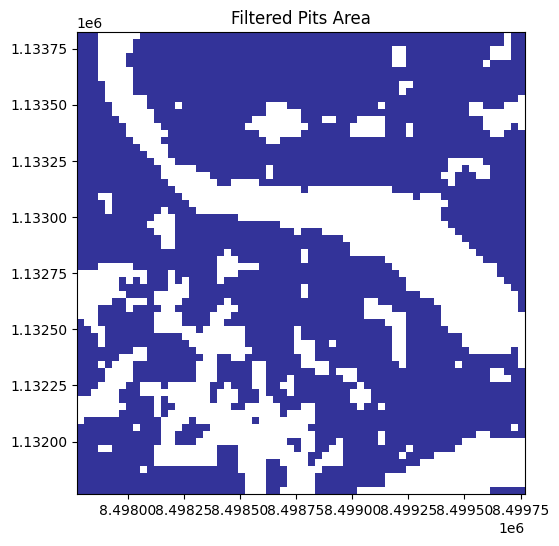

In [ ]:
# We will use the Ponding Area of Pits  / Small Scale Reservoirs
input_ponding_depth_path = "/content/ponding_depth.tif"
output_pits_filtered = "/content/pits_filtered.tif"
MINIMUM_DEPTH = 0.5 # In Meters
expression = f'("{input_ponding_depth_path}" > {MINIMUM_DEPTH})'
# print(inspect.getsource(wbt.raster_calculator))
wbt.raster_calculator(
    statement = expression,
    output  = output_pits_filtered,
)
print("SPI Hotspots saved as:", output_pits_filtered)
with rasterio.open(output_pits_filtered) as src:
    plt.figure(figsize=(6,6))
    plt.title("Filtered Pits Area")
    show(src, cmap="terrain")

## Vectorization

- Vectorize the Filtered Pits
- Add Area of the pit
- Add MEAN Depth of the pits
- ADD VOLUME of the pit